# Patlak Model

In [1]:
# import statements
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Background
[to do] some background on the method

## Test data

Data summary: simulated Patlak model data

Source: Concentration-time data (n = 9) generated by M. Thrippleton using Matlab code at https://github.com/mjt320/DCE-functions

Detailed info:
- Temporal resolution: 0.5 s
- Acquisition time: 300 s
- AIF: Parker function, starting at t=10s
- Noise: SD = 0.02 mM
- Arterial delay: none
 
Reference values: Reference values are the parameters used to generate the data. All combinations of $v_p$ (0.1, 0.2, 0.5) and PS (0, 5, 15)*1e-2 per min are included.
A delayed version of the test data was created by shifting the time curves with 5s. This data is labeled as 'delayed' and only used with the models that allow the fitting of a delay.

Citation: Code used in Manning et al., Magnetic Resonance in Medicine, 2021 https://doi.org/10.1002/mrm.28833 and Matlab code: https://github.com/mjt320/DCE-functions

Tolerances
- $v_p$: a_tol=0.025, r_tol=0, start=0.01, bounds=(0,1)
- PS: a_tol=0.005, r_tol=0.1, start=0.6, bounds=(0,5), units [/min]


### Visualize test data
To get an impression of the test data, the concentration time curves of the test data are plotted below.

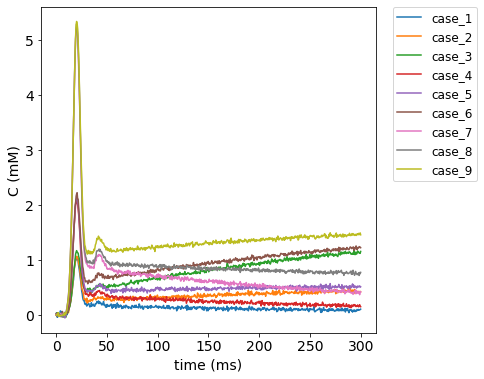

In [2]:
#plot test data
filename = ('../test/DCEmodels/data/patlak_sd_0.02_delay_0.csv')
# read from CSV to pandas
df1 = pd.read_csv(filename)

no_voxels = len(df1.label)

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(6,6))
for currentvoxel in range(no_voxels):
    labelname = 'case_' + str(currentvoxel+1)
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C_t'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax.plot(t, c, label=labelname)
    
ax.set_ylabel('C (mM)', fontsize=14)
ax.set_xlabel('time (ms)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=12);   
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

    

## Import data

In [3]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [4]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'DCEmodels') & (entry['method'] == 'patlak') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [5]:
author_list = df.author.unique()
no_authors = len(author_list)

# split delayed and non-delayed data
df['delay'] = df['label'].str.contains('_delayed')

# calculate error between measured and reference values
df['error_ps'] = df['ps_meas'] - df['ps_ref']
df['error_vp'] = df['vp_meas']- df['vp_ref']

# tolerances
tolerances = { 'ps': {'atol' : 0.005, 'rtol': 0.1 }, 'vp': {'atol':0.025, 'rtol':0}}

## Results

### Non-delayed data

Some models allow the fit of a delay. For the tests with non-delayed data, the delay was fixed to 0.
The data of all test voxels are combined (low and high SNR).

In [6]:
For the contribtution MJT_UoEdingburgh_UK there are two contributions (NLLS and LLSQ fitting approach). The linear approach is labeled with an extra tag _LLSQ in the figures below.

SyntaxError: invalid syntax. Perhaps you forgot a comma? (Temp/ipykernel_22828/1032621768.py, line 1)

In [ ]:
fig, ax = plt.subplots(1,2, sharey='none', figsize=(10,5))
plot_bland_altman(ax[0], df[~df['delay']], tolerances, 'ps', ylim=(-0.0075,0.0075),label_xaxis='$PS_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $PS$ ($min^{-1}$)')

plot_bland_altman(ax[1], df[~df['delay']], tolerances, 'vp', ylim=(-0.004,0.004),label_xaxis='$v_{p,ref}$ (-)',label_yaxis='$\Delta$ $v_{p}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='ContributionID', loc='upper left', borderaxespad=0, fontsize=12);


Bias results estimated PS values combined for all voxels

In [ ]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_ps',grouptag='author')
print(resultsBA)

Bias results estimated $v_p$ values combined for all voxels

In [ ]:
resultsBA = bland_altman_statistics(data=df[~df['delay']],par='error_vp',grouptag='author')
print(resultsBA)

### Delayed results

Some contributions allowed the fitting of a delay. For those, additional tests with a delay were performed.

In [ ]:
fig, ax = plt.subplots(1,2, sharey='none', figsize=(10,5))
plot_bland_altman(ax[0], df[df['delay']], tolerances, 'ps', ylim=(-0.0075,0.0075),label_xaxis='$PS_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $PS$ ($min^{-1}$)')

plot_bland_altman(ax[1], df[df['delay']], tolerances, 'vp', ylim=(-0.004,0.004),label_xaxis='$v_{p,ref}$ (-)',label_yaxis='$\Delta$ $v_{p}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='ContributionID', loc='upper left', borderaxespad=0, fontsize=12);


Bias results estimated PS values combined for all voxels

In [ ]:
resultsBA = bland_altman_statistics(data=df[df['delay']],par='error_ps',grouptag='author')
print(resultsBA)

Bias results estimated $v_p$ values combined for all voxels

In [ ]:
resultsBA = bland_altman_statistics(data=df[df['delay']],par='error_vp',grouptag='author')
print(resultsBA)

## Notes
Additional notes/remarks

### References